# Machine Learning Models For Motion Intention Using EMG Signals

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean
import math
from utils import *
from mlModels import *

from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
import sklearn.feature_selection as fs

import keras
import tensorflow as tf
from keras.models import load_model

In [2]:
keras.backend.clear_session()
print("GPUs Available: ", tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda())

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


## Load Data

In [3]:
w_length = 200
w_increment = 100

path = 'D:\Documentos\Datasets\Grabaciones 2'

raw_data, labels, angle, torque = loadAndLabel(path, w_length, w_increment)

1_ext_0_29_60.txt
1_flex_0_29_60.txt
1_pron_0_29_60.txt
1_stat_0_29_60.txt
1_sup_0_29_60.txt


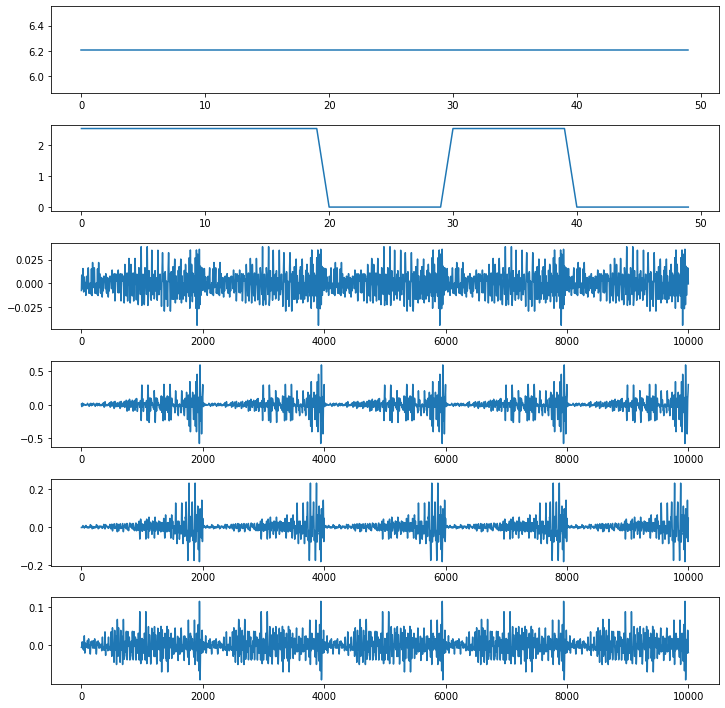

In [4]:
fig, axs = plt.subplots(6, figsize=(10,10))
fig.tight_layout()
plot_data_emg = np.vstack(raw_data)
plot_data_angle = np.vstack(angle)
plot_data_torque = np.vstack(torque)

n = 100000

axs[0].plot(plot_data_angle[0:n])
axs[1].plot(plot_data_torque[0:n])
axs[2].plot(plot_data_emg[0:n,0])
axs[3].plot(plot_data_emg[0:n,1])
axs[4].plot(plot_data_emg[0:n,2])
axs[5].plot(plot_data_emg[0:n,3])

In [5]:
w, ch = raw_data[0].shape
print('Number of examples (m) = ', len(raw_data))
print('Window lenght (w) = ', w)
print('Number of EMG channels (ch) = ', ch)

Number of examples (m) =  50
Window lenght (w) =  200
Number of EMG channels (ch) =  4


In [6]:
emg_raw_arr = np.array(raw_data)[:,:,0:4]
labels_arr = np.array(labels)
angle_arr = np.array(angle)
torque_arr = np.array(torque)
print(emg_raw_arr.shape)

(50, 200, 4)


## EMG Features

In [7]:
f_emg_data = EMGfeatures(emg_raw_arr)

sc = MinMaxScaler()
trans = sc.fit_transform(f_emg_data)

print(f_emg_data.shape)

(50, 44)


c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1999: UserWarning: nperseg = 256 is greater than input length  = 200, using nperseg = 200
  warnings.warn('nperseg = {0:d} is greater than input length '


## Moving Average Filter

In [8]:
maf_emg_data = maf(emg_raw_arr)

ascol = maf_emg_data.reshape(-1, ch)
sc = MinMaxScaler()
trans = sc.fit_transform(ascol)

maf_emg_data = trans.reshape(-1, w, ch)
print(maf_emg_data.shape)

maf_emg_data_flat = maf_emg_data.reshape(maf_emg_data.shape[0], w*ch)
print(maf_emg_data_flat.shape)

(50, 200, 4)
(50, 800)


## Autoencoder Feature Extraction

In [9]:
cnn_encoder = load_model('encoder_model.h5')
cnn_encoder.summary()

Model: "Convolutional_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 200, 4, 16)        272       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 100, 2, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 100, 2, 8)         520       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 50, 1, 8)         0         
 2D)                                                             
                                                                 
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________________


In [10]:
cnn_encoder.compile(optimizer='adam', loss='binary_crossentropy')
ae_emg = cnn_encoder.predict(emg_raw_arr)
print(ae_emg.shape)

ae_emg_data = ae_emg.reshape(ae_emg.shape[0], ae_emg.shape[1], ae_emg.shape[3])
print(ae_emg_data.shape)

ae_emg_data_flat = ae_emg.reshape(ae_emg.shape[0], -1)
print(ae_emg_data_flat.shape)

2/2 [==============================] - 4s 50ms/step
(50, 50, 1, 8)
(50, 50, 8)
(50, 400)


## Data Split

In [11]:
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(f_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_maf, X_test_maf, Y_train_maf, Y_test_maf = train_test_split(maf_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_maf_flat, X_test_maf_flat, Y_train_maf_flat, Y_test_maf_flat = train_test_split(maf_emg_data_flat, labels_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_ae, X_test_ae, Y_train_ae, Y_test_ae = train_test_split(ae_emg_data, labels_arr, stratify=labels, test_size=0.1, random_state=1)
X_train_ae_flat, X_test_ae_flat, Y_train_ae_flat, Y_test_ae_flat = train_test_split(ae_emg_data_flat, labels_arr, stratify=labels, test_size=0.1, random_state=1)

X_train_reg_feat, X_test_reg_feat, Y_train_reg_feat, Y_test_reg_feat = train_test_split(f_emg_data, torque_arr, test_size=0.1)
X_train_reg_maf, X_test_reg_maf, Y_train_reg_maf, Y_test_reg_maf = train_test_split(maf_emg_data, torque_arr, test_size=0.1)
X_train_reg_ae, X_tes_regt_ae, Y_train_reg_ae, Y_test_reg_ae = train_test_split(ae_emg_data, torque_arr, test_size=0.1)

# Classifiers Training

## EMG Features

In [12]:
models_classif, models_names_classif = sklearnModelsClassif()
train_scores, val_scores, cms = cvClassifiers(X_train_feat, Y_train_feat, models_classif, k=5)

c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\alejo\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATION

In [13]:
mlp_train_scores, mlp_val_scores = cvKeras(X_train_feat, Y_train_feat, mlp(), k = 5)
models_names_classif.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])

Epoch 1/10
2/2 [==============================] - 0s 3ms/step - loss: 13.7767 - Accuracy: 0.1944
Epoch 2/10
2/2 [==============================] - 0s 3ms/step - loss: 11.2685 - Accuracy: 0.1944
Epoch 3/10
2/2 [==============================] - 0s 5ms/step - loss: 9.1809 - Accuracy: 0.1944
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 7.3906 - Accuracy: 0.1944
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 6.0624 - Accuracy: 0.1667
Epoch 6/10
2/2 [==============================] - 0s 3ms/step - loss: 5.2434 - Accuracy: 0.1389
Epoch 7/10
2/2 [==============================] - 0s 3ms/step - loss: 4.8340 - Accuracy: 0.1667
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 4.6037 - Accuracy: 0.1944
Epoch 9/10
2/2 [==============================] - 0s 3ms/step - loss: 4.4302 - Accuracy: 0.1944
Epoch 10/10
1/1 [==============================] - 0s 15ms/step - loss: 3.6228 - Accuracy: 0.2222
Epoch 1/10
2/2 [====================

In [14]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['Accuracy', 'F1-Score']],names=['','Model'])
models_comparison_classif = pd.DataFrame(zip(train_scores[0], train_scores[1], val_scores[0], val_scores[1]), index=models_names_classif, columns=cols)
models_comparison_classif = models_comparison_classif.sort_values([('Val', 'Accuracy')], ascending=False)
models_comparison_classif


Train                 Val          
Model                Accuracy  F1-Score  Accuracy  F1-Score
Stacking             0.105556  0.072421  0.422222  0.390286
Deep MLP             0.194444  0.105539  0.200000  0.102641
SVM                  0.222222  0.072727  0.111111  0.040000
Naive Bayes          0.255556  0.189514  0.088889  0.050317
KNN                  0.266667  0.224018  0.022222  0.016000
Logistic Regression  0.272222  0.248200  0.022222  0.020000
MLP                  0.272222  0.235017  0.022222  0.008889
Decision Tree        0.277778  0.165278  0.000000  0.000000
LDA                  0.277778  0.241929  0.000000  0.000000
Bagging              0.277778  0.232636  0.000000  0.000000
AdaBoost             0.277778  0.236126  0.000000  0.000000
Gradient Boosting    0.277778  0.240862  0.000000  0.000000
Random Forest        0.277778  0.248811  0.000000  0.000000

## Moving Average Filter

In [15]:
models_classif, models_names_classif = sklearnModelsClassif()
train_scores, val_scores, cms = cvClassifiers(X_train_maf_flat, Y_train_maf_flat, models_classif, k=5)

In [16]:
mlp_train_scores, mlp_val_scores = cvKeras(X_train_maf_flat, Y_train_maf_flat, mlp(), k = 5)
models_names_classif.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])

Epoch 1/10
2/2 [==============================] - 0s 5ms/step - loss: 1.6247 - Accuracy: 0.2222
Epoch 2/10
2/2 [==============================] - 0s 5ms/step - loss: 1.5884 - Accuracy: 0.1944
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 1.5880 - Accuracy: 0.2500
Epoch 4/10
2/2 [==============================] - 0s 3ms/step - loss: 1.5909 - Accuracy: 0.2500
Epoch 5/10
2/2 [==============================] - 0s 4ms/step - loss: 1.5890 - Accuracy: 0.2500
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6052 - Accuracy: 0.2500
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6115 - Accuracy: 0.2500
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6084 - Accuracy: 0.2500
Epoch 9/10
2/2 [==============================] - 0s 5ms/step - loss: 1.5997 - Accuracy: 0.1944
Epoch 10/10
1/1 [==============================] - 0s 21ms/step - loss: 1.8887 - Accuracy: 0.2222
Epoch 1/10
2/2 [======================

In [20]:
cnn_train_scores, cnn_val_scores = cvKeras(X_train_maf.reshape(X_train_maf.shape[0],w,ch,1), Y_train_maf, cnn(), k = 5)
models_names_classif.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])

Epoch 1/10
2/2 [==============================] - 0s 5ms/step - loss: 1.6140 - Accuracy: 0.1944
Epoch 2/10
2/2 [==============================] - 0s 8ms/step - loss: 1.6068 - Accuracy: 0.1944
Epoch 3/10
2/2 [==============================] - 0s 7ms/step - loss: 1.6066 - Accuracy: 0.1944
Epoch 4/10
2/2 [==============================] - 0s 6ms/step - loss: 1.6023 - Accuracy: 0.1667
Epoch 5/10
2/2 [==============================] - 0s 8ms/step - loss: 1.6016 - Accuracy: 0.1667
Epoch 6/10
2/2 [==============================] - 0s 8ms/step - loss: 1.6012 - Accuracy: 0.2222
Epoch 7/10
2/2 [==============================] - 0s 7ms/step - loss: 1.5998 - Accuracy: 0.2500
Epoch 8/10
2/2 [==============================] - 0s 7ms/step - loss: 1.5992 - Accuracy: 0.2500
Epoch 9/10
2/2 [==============================] - 0s 6ms/step - loss: 1.5986 - Accuracy: 0.2500
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 1.6331 - Accuracy: 0.0000e+00
Epoch 1/10
2/2 [==================

In [22]:
lstm_train_scores, lstm_val_scores = cvKeras(X_train_maf, Y_train_maf, lstm_rnn(), k = 5)
models_names_classif.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])

Epoch 1/10
2/2 [==============================] - 1s 23ms/step - loss: 1.6104 - Accuracy: 0.1944
Epoch 2/10
2/2 [==============================] - 0s 29ms/step - loss: 1.6089 - Accuracy: 0.1944
Epoch 3/10
2/2 [==============================] - 0s 24ms/step - loss: 1.6087 - Accuracy: 0.1944
Epoch 4/10
2/2 [==============================] - 0s 25ms/step - loss: 1.6080 - Accuracy: 0.1667
Epoch 5/10
2/2 [==============================] - 0s 25ms/step - loss: 1.6076 - Accuracy: 0.1944
Epoch 6/10
2/2 [==============================] - 0s 20ms/step - loss: 1.6071 - Accuracy: 0.2222
Epoch 7/10
2/2 [==============================] - 0s 19ms/step - loss: 1.6066 - Accuracy: 0.2222
Epoch 8/10
2/2 [==============================] - 0s 19ms/step - loss: 1.6063 - Accuracy: 0.2500
Epoch 9/10
2/2 [==============================] - 0s 21ms/step - loss: 1.6059 - Accuracy: 0.2500
Epoch 10/10
1/1 [==============================] - 0s 23ms/step - loss: 1.6219 - Accuracy: 0.1111
Epoch 1/10
2/2 [=============

In [23]:
gru_train_scores, gru_val_scores = cvKeras(X_train_maf, Y_train_maf, gru_rnn(), k = 5)
models_names_classif.append('LSTM')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])

Epoch 1/10
2/2 [==============================] - 1s 23ms/step - loss: 1.6122 - Accuracy: 0.1944
Epoch 2/10
2/2 [==============================] - 0s 23ms/step - loss: 1.6108 - Accuracy: 0.2222
Epoch 3/10
2/2 [==============================] - 0s 22ms/step - loss: 1.6099 - Accuracy: 0.2222
Epoch 4/10
2/2 [==============================] - 0s 18ms/step - loss: 1.6097 - Accuracy: 0.2500
Epoch 5/10
2/2 [==============================] - 0s 19ms/step - loss: 1.6102 - Accuracy: 0.1944
Epoch 6/10
2/2 [==============================] - 0s 20ms/step - loss: 1.6100 - Accuracy: 0.1944
Epoch 7/10
2/2 [==============================] - 0s 25ms/step - loss: 1.6099 - Accuracy: 0.1944
Epoch 8/10
2/2 [==============================] - 0s 17ms/step - loss: 1.6097 - Accuracy: 0.1944
Epoch 9/10
2/2 [==============================] - 0s 17ms/step - loss: 1.6093 - Accuracy: 0.1944
Epoch 10/10
1/1 [==============================] - 0s 23ms/step - loss: 1.6180 - Accuracy: 0.2222
Epoch 1/10
2/2 [=============

In [24]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['Accuracy', 'F1-Score']],names=['','Model'])
models_comparison_classif = pd.DataFrame(zip(train_scores[0], train_scores[1], val_scores[0], val_scores[1]), index=models_names_classif, columns=cols)
models_comparison_classif = models_comparison_classif.sort_values([('Val', 'Accuracy')], ascending=False)
models_comparison_classif

Train                 Val          
Model                Accuracy  F1-Score  Accuracy  F1-Score
Stacking             0.150000  0.100292  0.311111  0.240190
LSTM                 0.216667  0.104737  0.155556  0.063980
LSTM                 0.222222  0.105629  0.133333  0.057333
CNN                  0.227778  0.129638  0.133333  0.050424
Deep MLP             0.227778  0.155490  0.133333  0.052641
LSTM                 0.244444  0.145569  0.111111  0.054095
CNN                  0.250000  0.149666  0.088889  0.038222
Naive Bayes          0.272222  0.221583  0.022222  0.011429
SVM                  0.272222  0.158441  0.022222  0.008000
AdaBoost             0.277778  0.238202  0.000000  0.000000
Decision Tree        0.277778  0.165278  0.000000  0.000000
Random Forest        0.277778  0.244895  0.000000  0.000000
Bagging              0.277778  0.234051  0.000000  0.000000
MLP                  0.277778  0.218370  0.000000  0.000000
Logistic Regression  0.277778  0.248786  0.000000  0.000000
LDA                  0.277778  0.236149  0.000000  0.000000
KNN                  0.277778  0.244566  0.000000  0.000000
Gradient Boosting    0.277778  0.217145  0.000000  0.000000

## Autoencoder Feature Extraction

In [25]:
models_classif, models_names_classif = sklearnModelsClassif()
train_scores, val_scores, cms = cvClassifiers(X_train_maf_flat, Y_train_maf_flat, models_classif, k=5)

In [26]:
mlp_train_scores, mlp_val_scores = cvKeras(X_train_ae_flat, Y_train_ae_flat, mlp(), k = 5)
models_names_classif.append('Deep MLP')
train_scores[0].append(mlp_train_scores[0])
train_scores[1].append(mlp_train_scores[1])
val_scores[0].append(mlp_val_scores[0])
val_scores[1].append(mlp_val_scores[1])

Epoch 1/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6053 - Accuracy: 0.2222
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 1.5952 - Accuracy: 0.2222
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 1.5881 - Accuracy: 0.2222
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 1.5839 - Accuracy: 0.2222
Epoch 5/10
2/2 [==============================] - 0s 5ms/step - loss: 1.5817 - Accuracy: 0.2222
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 1.5795 - Accuracy: 0.2222
Epoch 7/10
2/2 [==============================] - 0s 5ms/step - loss: 1.5766 - Accuracy: 0.2222
Epoch 8/10
2/2 [==============================] - 0s 4ms/step - loss: 1.5736 - Accuracy: 0.2222
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 1.5701 - Accuracy: 0.2222
Epoch 10/10
1/1 [==============================] - 0s 18ms/step - loss: 1.8028 - Accuracy: 0.1111
Epoch 1/10
2/2 [======================

In [27]:
cnn_train_scores, cnn_val_scores = cvKeras(X_train_ae.reshape(X_train_ae.shape[0],X_train_ae.shape[1],X_train_ae.shape[2],1), Y_train_ae, cnn(), k = 5)
models_names_classif.append('CNN')
train_scores[0].append(cnn_train_scores[0])
train_scores[1].append(cnn_train_scores[1])
val_scores[0].append(cnn_val_scores[0])
val_scores[1].append(cnn_val_scores[1])

Epoch 1/10
2/2 [==============================] - 1s 80ms/step - loss: 1.6146 - Accuracy: 0.1667
Epoch 2/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6119 - Accuracy: 0.1667
Epoch 3/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6105 - Accuracy: 0.1944
Epoch 4/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6096 - Accuracy: 0.1944
Epoch 5/10
2/2 [==============================] - 0s 3ms/step - loss: 1.6084 - Accuracy: 0.2778
Epoch 6/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6076 - Accuracy: 0.2500
Epoch 7/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6058 - Accuracy: 0.2500
Epoch 8/10
2/2 [==============================] - 0s 5ms/step - loss: 1.6036 - Accuracy: 0.2500
Epoch 9/10
2/2 [==============================] - 0s 4ms/step - loss: 1.6021 - Accuracy: 0.2500
Epoch 10/10
1/1 [==============================] - 0s 15ms/step - loss: 1.6427 - Accuracy: 0.1111
Epoch 1/10
2/2 [=====================

In [28]:
lstm_train_scores, lstm_val_scores = cvKeras(X_train_ae, Y_train_ae, lstm_rnn(), k = 5)
models_names_classif.append('LSTM')
train_scores[0].append(lstm_train_scores[0])
train_scores[1].append(lstm_train_scores[1])
val_scores[0].append(lstm_val_scores[0])
val_scores[1].append(lstm_val_scores[1])

Epoch 1/10
2/2 [==============================] - 1s 11ms/step - loss: 1.6114 - Accuracy: 0.1944
Epoch 2/10
2/2 [==============================] - 0s 11ms/step - loss: 1.6101 - Accuracy: 0.1944
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - loss: 1.6099 - Accuracy: 0.2222
Epoch 4/10
2/2 [==============================] - 0s 13ms/step - loss: 1.6099 - Accuracy: 0.2222
Epoch 5/10
2/2 [==============================] - 0s 11ms/step - loss: 1.6096 - Accuracy: 0.1944
Epoch 6/10
2/2 [==============================] - 0s 11ms/step - loss: 1.6096 - Accuracy: 0.2222
Epoch 7/10
2/2 [==============================] - 0s 12ms/step - loss: 1.6093 - Accuracy: 0.2222
Epoch 8/10
2/2 [==============================] - 0s 11ms/step - loss: 1.6092 - Accuracy: 0.2222
Epoch 9/10
2/2 [==============================] - 0s 12ms/step - loss: 1.6091 - Accuracy: 0.2222
Epoch 10/10
1/1 [==============================] - 0s 21ms/step - loss: 1.6175 - Accuracy: 0.1111
Epoch 1/10
2/2 [=============

In [29]:
gru_train_scores, gru_val_scores = cvKeras(X_train_ae, Y_train_ae, gru_rnn(), k = 5)
models_names_classif.append('GRU')
train_scores[0].append(gru_train_scores[0])
train_scores[1].append(gru_train_scores[1])
val_scores[0].append(gru_val_scores[0])
val_scores[1].append(gru_val_scores[1])

Epoch 1/10
2/2 [==============================] - 2s 10ms/step - loss: 1.6091 - Accuracy: 0.2222
Epoch 2/10
2/2 [==============================] - 0s 9ms/step - loss: 1.6086 - Accuracy: 0.2222
Epoch 3/10
2/2 [==============================] - 0s 10ms/step - loss: 1.6084 - Accuracy: 0.2222
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 1.6083 - Accuracy: 0.2222
Epoch 5/10
2/2 [==============================] - 0s 12ms/step - loss: 1.6084 - Accuracy: 0.1944
Epoch 6/10
2/2 [==============================] - 0s 11ms/step - loss: 1.6084 - Accuracy: 0.2222
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 1.6085 - Accuracy: 0.1944
Epoch 8/10
2/2 [==============================] - 0s 10ms/step - loss: 1.6085 - Accuracy: 0.1944
Epoch 9/10
2/2 [==============================] - 0s 10ms/step - loss: 1.6085 - Accuracy: 0.1944
Epoch 10/10
1/1 [==============================] - 0s 19ms/step - loss: 1.6113 - Accuracy: 0.2222
Epoch 1/10
2/2 [==============

In [30]:
cols = pd.MultiIndex.from_product([['Train', 'Val'], ['Accuracy', 'F1-Score']],names=['','Model'])
models_comparison_classif = pd.DataFrame(zip(train_scores[0], train_scores[1], val_scores[0], val_scores[1]), index=models_names_classif, columns=cols)
models_comparison_classif = models_comparison_classif.sort_values([('Val', 'Accuracy')], ascending=False)
models_comparison_classif

Train                 Val          
Model                Accuracy  F1-Score  Accuracy  F1-Score
Stacking             0.150000  0.094130  0.311111  0.240190
CNN                  0.227778  0.136794  0.177778  0.083752
LSTM                 0.216667  0.085746  0.155556  0.054545
LSTM                 0.227778  0.117034  0.155556  0.069752
Deep MLP             0.233333  0.146883  0.133333  0.062984
Naive Bayes          0.272222  0.221583  0.022222  0.011429
SVM                  0.272222  0.158441  0.022222  0.008000
Decision Tree        0.277778  0.165278  0.000000  0.000000
KNN                  0.277778  0.244566  0.000000  0.000000
LDA                  0.277778  0.236149  0.000000  0.000000
Logistic Regression  0.277778  0.248786  0.000000  0.000000
MLP                  0.277778  0.189805  0.000000  0.000000
Bagging              0.277778  0.257935  0.000000  0.000000
AdaBoost             0.277778  0.241430  0.000000  0.000000
Gradient Boosting    0.277778  0.217145  0.000000  0.000000
Random Forest        0.277778  0.246968  0.000000  0.000000

# Feature selection and extraction

## Principal Component Analysis

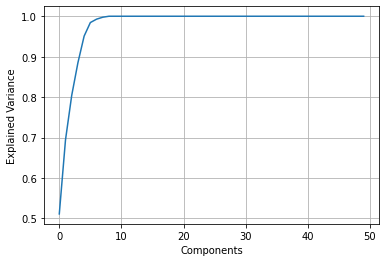

In [34]:
pca = PCA().fit(ae_emg_data_flat)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.grid(True)

Text(0, 0.5, 'Component 2')

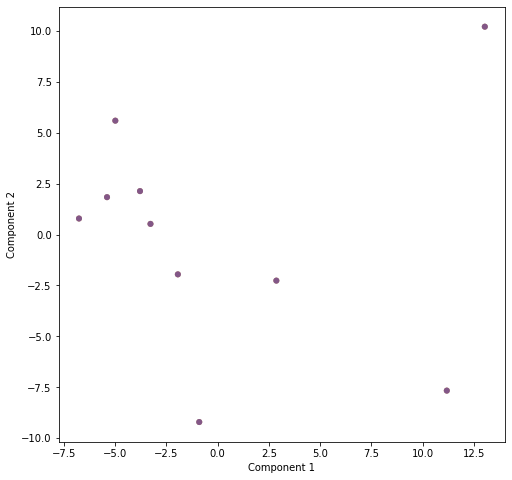

In [40]:
pca = PCA(2)
projected = pca.fit_transform(f_emg_data)
plt.figure(figsize=(8,8))
plt.scatter(projected[:,0], projected[:,1],
            c=labels_arr, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Spectral', 10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')

## Filter selection - Select K Best

In [ ]:
f1_list = []
accuracy_list=[]
for k in range(1, X.shape[1]):

  bk = fs.SelectKBest(fs.f_classif, k=k)
  bk.fit(X_train, Y_train)

  X_train_trans = bk.transform(X_train)
  X_test_trans = bk.transform(X_test)

  lr = RandomForestClassifier()
  lr.fit(X_train_trans, Y_train)

  y_pred = lr.predict(X_test_trans)
  accuracy = accuracy_score(Y_test, y_pred)
  accuracy_list.append(accuracy)
  f1 = f1_score(Y_test, y_pred, average='macro')
  f1_list.append(f1)

fig, axe = plt.subplots(1,2,figsize=(15,5))
axe[0].plot(range(1, X.shape[1]), accuracy_list)
axe[0].set_xlabel("Mejores k rasgos")
axe[0].set_ylabel("Accuracy")
axe[1].plot(range(1, X.shape[1]), f1_list)
axe[1].set_xlabel("Mejores k rasgos")
axe[1].set_ylabel("F1-score")
plt.show()
print(np.argmax(accuracy_list))
print(max(accuracy_list))
print(max(f1_list))

# Hyperparameter Optimization